<a href="https://colab.research.google.com/github/gasparfj/K-neighbors_protein_structure_predict/blob/main/PAC1_GFJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRUEBA DE EVALUACIÓN CONTINUA 1

Machine Learning

Gaspar Fuster Jiménez

20/10/2025


---



In [ ]:
# Importar librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score



---



## 1. Algoritmo k-NN

El algoritmo K vecinos más cercanos (k-NN) se puede utilizar para para clasificación y para regresión. Su predicción se basa en las k muestras de entrenamiento más ceranas a la muestra a predecir; en un problema de clasificaciónc (como el que veremos a continuación) la predicción será la clase más frecuente de sus k vecinos; en cambio, en un problema de regresión, esta predicción será el valor promedio de estos k vecinos.

Escoger el número de vecions a utilizar es una elección crucial, ya que la predicción dependerá de este valor, por lo que es recomendable probar diferentes k y evaluar la capacidad de predicción para cada k.

Este algoritmo destaca por su simpleza y eficacia en la predicción. Además es un modeo no paramétrico, por lo que no asume ninguna distribución de los datos. En cuanto a sus debilidades, es importante señalar que este algoritmo no produce un modelo, ya que para cada predicción se calculan todas las distancias del punto a predecir, lo que a su vez implica que el k-NN es un gran consumidor de memoria. Otro punto negativo del k-NN es la necesidad de realizar procesos de imputación si hay presencia de valores nulos.

## 2. Desarrollar una función en Python que implemente una codificación "one-hot" (one-hot encoding) de las secuencias.

En el siguiente bloque de código se crea una función que implementará una codificación "one-hot" de las secuencias proteicas usando el orden alfabético del código de tres letras de los aminoácidos (ver Tabla 1, copiada de [Wikipedia](https://es.wikipedia.org/wiki/Nomenclatura_de_amino%C3%A1cidos)).

Esta función va a omitir la última columna del data frame que se corresponde a la estructura secundaria de la estructura secundaria del aminoácido central. Por esa razón, si se utiliza esta función con otros datos, es importante verificar que la última columna se corresponde con la estructura secundaria.

Esta función va a retornar un Data Frame del mismo número de filas que secuencias y de 17 posiciones x 20 aminoácidos = 340 columnas.

| Aminoácido          | Código de tres letras | Código de una letra |
|---------------------|:---------------------:|:-------------------:|
| Alanina             | Ala                   | A                   |
| Arginina            | Arg                   | R                   |
| Asparagina          | Asn                   | N                   |
| Ácido aspártico     | Asp                   | D                   |
| Cisteína            | Cys                   | C                   |
| Glutamina           | Gln                   | Q                   |
| Ácido glutámico     | Glu                   | E                   |
| Glicina             | Gly                   | G                   |
| Histidina           | His                   | H                   |
| Isoleucina          | Ile                   | I                   |
| Leucina             | Leu                   | L                   |
| Lisina              | Lys                   | K                   |
| Metionina           | Met                   | M                   |
| Fenilalanina        | Phe                   | F                   |
| Prolina             | Pro                   | P                   |
| Serina              | Ser                   | S                   |
| Treonina            | Thr                   | T                   |
| Triptófano          | Trp                   | W                   |
| Tirosina            | Tyr                   | Y                   |
| Valina              | Val                   | V                   |

**Tabla1: Nomenclatura de los aminoácidos.**

In [ ]:
def onehot_encoding(df): # Definir la funcion

  df_mod = df.iloc[:, :-1] # df modificado sin la columna de las clases de la estructura
  ## Para utilizar esta funcion el df debe contener la columna de las estructuras
  ## en la ultima columna, de lo contrario, modificar esta linea de codigo

  # Codigo de los aminoacidos
  aminoacids = ['A', 'R', 'N', 'D', 'C',
              'Q', 'E', 'G', 'H', 'I',
              'L', 'K', 'M', 'F', 'P',
              'S', 'T', 'W', 'Y', 'V']
  # Enumerar los indices de la lista anterior
  index_aa = {aa : i for i, aa in enumerate(aminoacids)}

  # Iniciar una matriz de 0s
  onehot = np.zeros((df_mod.shape[0], df_mod.shape[1]*20), dtype=int)

  for i, col in enumerate(df_mod.columns): # Iterar sobre cada columna
    for j, aa in enumerate(df_mod[col]): # Iterar sobre cada fila de la columna
      if aa in index_aa: # Si el aminoacido de la posicion en el momento esta en la lista aminoacids
        idx = i * 20 + index_aa[aa] # Calcular el indice del aminoacido
        onehot[j, idx] = 1 # Añadir el 1

  onehot_df = pd.DataFrame(onehot) # Convertir la matriz a data frame

  return onehot_df # Devolver el data frame final

## 3. Desarrollar un script en Python que implemente un clasificador knn. El script debe realizar los siguientes apartados:

### (a) Leer el fichero data4.csv. Cada registro contiene una secuencia de 17 aminoácidos y la clase de estructura secundaria correspondiente al aminoácido central (posición 9), donde los caracteres 'h', 'e' y '_' representan α-helix, β-sheet y coil, respectivamente. Después de cargar los datos, crear una tabla donde se muestre el número de secuencias de cada clase.

In [ ]:
# Seleccionar un archivo local
from google.colab import files
uploaded = files.upload()

Saving data4.csv to data4.csv


In [ ]:
# Leer el csv seleccionadao con pandas
data = pd.read_csv('data4.csv', sep=';')
print(f"Na: {data.isna().sum().sum()}") # Numero de valores Na del modelo
data.head(5) # Ver las 5 primeras filas del df

Na: 0


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18
0,S,S,P,F,S,Q,K,G,D,E,R,Y,K,Y,V,D,P,_
1,L,L,Q,Y,Y,G,M,T,E,M,N,Y,Y,T,V,L,F,_
2,L,L,N,P,K,K,Y,I,P,G,T,K,M,V,F,P,G,_
3,L,L,N,A,K,G,E,T,F,E,V,A,L,S,N,K,G,e
4,T,V,S,F,E,A,T,F,A,F,L,I,K,S,P,D,S,e


Como se ha mencionado en el apartdado 1 (Algoritmo k-NN) es importante verificar que en los datos no hay valores nulos, ya que en caso contrario se tendrian que aplicar procesos de imputación.

En este caso se ha confirmado que no hay valores nulos.

In [ ]:
estr = ['Alpha-helix', 'Beta-sheet', 'Coil'] # Lista de tipos de estructura
# Contar las veces que se repite cada una y guardarlo en otra lista
cont = [
    data['V18'].value_counts()['h'],
    data['V18'].value_counts()['e'],
    data['V18'].value_counts()['_']
]
# Juntar las dos listas en un df
tabla = pd.DataFrame({'Estructura': estr,'Recuento': cont})
display(tabla.style.hide(axis="index")) # Mostrar el df

Estructura,Recuento
Alpha-helix,2508
Beta-sheet,1935
Coil,5557


### (b) Utilizar la función de codificación "one-hot" para representar las secuencias.

In [ ]:
X = onehot_encoding(data) # Guardar el resultado en una variable X
X.head(5) # Ver las 5 primeras columnas

,0,1,2,3,4,5,6,7,8,9,...,330,331,332,333,334,335,336,337,338,339
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### (c) Utilizando la semilla aleatoria 4671, separar los datos en dos partes, una parte para training (67%) y una parte para test (33%).

In [ ]:
y = data['V18'] # Gurdar en variable "y" los datos del target
# Dividir en train y test manteniendo correspondencia
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4671)

### (d) Utilizar un knn (k = 1, 3, 5, 7, 11) basado en el training para predecir la estructura secundaria de las secuencias del test.

Se utiliza un bucle `for` para ejecutar el algoritmo para cada valor de k.

In [ ]:
k_valores = [1, 3, 5, 7, 11] # Lista con los valores k del enunciado

for k in k_valores: # Iterar sobre cada valor k de la lista
  # Crear el modelo knn por cada numero k de vecinos
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train) # Ajustar el modelo con los datos de entrenamiento
  y_pred = knn.predict(X_test) # Predecir la estructura con los datos de prueba
  e = 1 - accuracy_score(y_test, y_pred) # Calcular el error (1-accuracy)
  print(f"k = {k}: error = {e:.3f}") # Mostrar el error
  kappa = cohen_kappa_score(y_test, y_pred) # Calcular el valor de kappa
  print(f"k = {k}: kappa = {kappa:.3f}") # Mostrar kappa
  print() # Espacio entre diferentes k vecinos

k = 1: error = 0.256
k = 1: kappa = 0.567

k = 3: error = 0.299
k = 3: kappa = 0.470

k = 5: error = 0.332
k = 5: kappa = 0.399

k = 7: error = 0.349
k = 7: kappa = 0.357

k = 11: error = 0.373
k = 11: kappa = 0.296



### (e) Por otra parte, sabemos que las clases α-helix y β-sheet son del tipo non-coil. Realizar otro knn (k = 1, 3, 5, 7, 11) para esta nueva clasificación, coil y non-coil. Además, realizar una curva ROC para cada k y calcular su área bajo la curva (AUC).

In [ ]:
# Crear nueva variable con los datos de estrucura modificando los valores
# de "h" y "e" por "non-coil" y los valores "_" por coil
y2 = data['V18'].apply(lambda i: "non-coil" if i in ["h", "e"] else "coil")
y2.head(5) # Mostrar las 5 primeras filas de la variable creada

,V18
0,coil
1,coil
2,coil
3,non-coil
4,non-coil


k = 1: error = 0.217
k = 1: kappa = 0.560
k = 1: TP = 1110, FP = 357, TN = 1473, FN = 360

k = 3: error = 0.262
k = 3: kappa = 0.468
k = 3: TP = 1014, FP = 408, TN = 1422, FN = 456

k = 5: error = 0.284
k = 5: kappa = 0.420
k = 5: TP = 939, FP = 406, TN = 1424, FN = 531

k = 7: error = 0.304
k = 7: kappa = 0.379
k = 7: TP = 895, FP = 428, TN = 1402, FN = 575

k = 11: error = 0.335
k = 11: kappa = 0.314
k = 11: TP = 836, FP = 472, TN = 1358, FN = 634



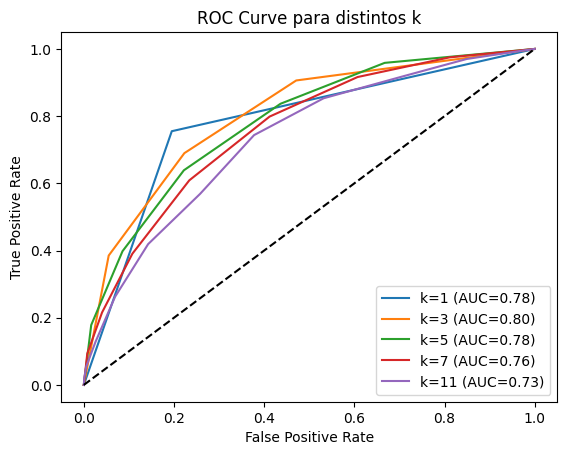

In [ ]:
# Separar los datos en entrenamiento y prueba con la nueva y (y2)
X_train, X_test, y_train2, y_test2 = train_test_split(X, y2, test_size=0.33, random_state=4671)
# Convertir esta y en binario (non-coil = 0 y coil = 1)
y_test_bin = label_binarize(y_test2, classes=['coil', 'non-coil'])

for k in k_valores: # Iterar sobre cada k de la lista anterior
  # Crear el modelo knn por cada numero k de vecinos
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train2) # Ajustar el modelo con los datos de entrenamiento
  y_pred2 = knn.predict(X_test) # Predecir la estructura con los datos de prueba
  e = 1 - accuracy_score(y_test2, y_pred2) # Calcular el error (1-accuracy)
  print(f"k = {k}: error = {e:.3f}") # Mostrar el error

  kappa = cohen_kappa_score(y_test2, y_pred2) # Calcular el valor de kappa
  print(f"k = {k}: kappa = {kappa:.3f}") # Mostrar kappa

  # Guardar la probabilidad de pertenecer a la clase coil
  y_score = knn.predict_proba(X_test)[:, knn.classes_.tolist().index('non-coil')]

  # Calcular los ratios de falsos y veraderos positivos para cada ubral
  fpr, tpr, tresholds = roc_curve(y_test_bin, y_score)
  roc_auc = auc(fpr, tpr) # Calcular el area bajo la curva

  # Calcular la matriz de confusion
  cm = confusion_matrix(y_test2, y_pred2, labels=['coil', 'non-coil'])
  tn, fp, fn, tp = cm.ravel() # Extraer los datos de la matriz de confusion

  print(f"k = {k}: TP = {tp}, FP = {fp}, TN = {tn}, FN = {fn}")

  print() # Espacio entre diferentes k vecinos

  # Representar la curva ROC para cada k
  plt.plot(fpr, tpr, label=f"k={k} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')  # Linea diagonal
plt.xlabel("False Positive Rate") # Titulo eje x
plt.ylabel("True Positive Rate") # Titulo eje y
plt.title("ROC Curve para distintos k") # Titulo del grafico
plt.legend() # Incluir leyenda
plt.show() # Mostrar el grafico

### f) Comentar los resultados de la clasificación para las tres clases de estructuras secundarias basado, como mínimo, en el error de clasificación y el valor de kappa. Además, comentar los resultados para las clases coil y non-coil en función del AUC, número de falsos positivos, falsos negativos y error de clasificación. En ambos casos tener en cuenta los resultados obtenidos para los diferentes valores de k. La clase que será asignada como positiva en la clasificación binaria es la non-coil. Finalmente, comentar globalmente los resultados de ambas clasificaciones.

En primer lugar, al predecir los tres tipos de estructura, un menor número de vecinos da una predicción más exacta en tanto que el 1 vecino es el valor con el que se obtiene una mejor predicción, con un error 0.256 (1-accuracy) y un valor kappa de 0.567, lo que indica un acuerdo aceptable entre las valores perdichos con los datos de entrenamiento y los datos reales.

Por otra parte, al simplificar el modelo (con solo dos clases de estructuras: "coil" y "non-coil"), la capacidad de predicción del modelo mejora ligeramente. El número de vecinos con una mayor predicción continua siendo 1, con un error y un valor kappa para esta k de 0.217 y 0.560 respectivamente.

Finalmente, aunque el error y el valor kappa indican que el mejor ajuste es con un vecino, los valores de AUC sugieren que el algoritmo con 3 vecinos tiene una mayor capacidad de discriminación por lo que es preferibel al evaluar nuevos datos. En cambio, con 1 vecino, el algoritmo memoriza mejor los datos y ofrece una mayor precisón, con menos falsos positivos y negativos que con k=3.


| k | Error | Kappa | AUC | Falsos Positivos (FP) | Falsos Negativos (FN) |
| :---: | :---: | :---: | :---: | :---: | :---: |
| **1** | 0.217 | 0.560 | 0.78 | 357 | 360 |
| **3** | 0.262 | 0.468 | 0.80 | 408 | 456 |
| **5** | 0.284 | 0.420 | 0.78 | 406 | 531 |
| **7** | 0.304 | 0.379 | 0.76 | 428 | 575 |
| **11**| 0.335 | 0.314 | 0.73 | 472 | 634 |

**Tabla 2: Comparación del algoritmo (con solo 2 clases a predecir) con 1, 3, 5, 7 y 11 k vecinos.**